## ПРОЕКТ##

Есть стартап, который создает новый маркетплейс. Он недавно появился на рынке и занимается продажей новых товаров из Бразилии, которые только начинают поступать в продажу. Выручка маркетплейса стоит на месте уже несколько месяцев. 

### **Задача 1.**###

**Оценить месячный retention в оформление заказа с помощью когортного анализа.**

В рамках исследования необходимо:

- Исследовать датасет и определить, какой вид заказа будет учитываться в retention

- Построить месячный retention

- Проанализировать, чему равен медианный retention 1-го месяца 
(т.е. взять retention 1-ого месяца для всех когорт и посчитать по этим числам медиану)

- Найти когорту с самым высоким retention на 3-й месяц.

Файлы:

 **olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей**
 
customer_id — позаказный идентификатор пользователя

customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)

customer_zip_code_prefix — почтовый индекс пользователя

customer_city — город доставки пользователя

customer_state — штат доставки пользователя

  **olist_orders_dataset.csv —  таблица заказов**

order_id — уникальный идентификатор заказа (номер чека)

customer_id — позаказный идентификатор пользователя

order_status — статус заказа

order_purchase_timestamp — время создания заказа

order_approved_at — время подтверждения оплаты заказа

order_delivered_carrier_date — время передачи заказа в логистическую службу

order_delivered_customer_date — время доставки заказа

order_estimated_delivery_date — обещанная дата доставки

  **olist_order_items_dataset.csv — товарные позиции, входящие в заказы

order_id — уникальный идентификатор заказа (номер чека)

order_item_id — идентификатор товара внутри одного заказа

product_id — ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price — цена за единицу товара

freight_value — вес товара 

Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created — создан;
approved — подтверждён;
invoiced — выставлен счёт;
processing — в процессе сборки заказа;
shipped — отгружён со склада;
delivered — доставлен пользователю;
unavailable — заказ отменён по причине недоступности товара;;
canceled — отменён.

**1. Исследуем датасеты и определить, какой вид заказа будет учитываться в retention**

Для оценки месячного retention (возвратности) клиентов в оформлении заказа с помощью когортного анализа, мы будем использовать два датасета: olist_customers_dataset.csv, olist_orders_dataset.cs. Для расчета retetion будем учитывать вид заказа со статусом delivered 

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
order_items=pd.read_csv('olist_order_items_dataset.csv')

df = orders.merge(customers[['customer_id', 'customer_unique_id', 'customer_state', 'customer_city']], on='customer_id')
df = df.merge(order_items[['order_id','product_id']], on='order_id')
df = df[df['order_status'] == 'delivered'].copy()

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [46]:
df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
customer_unique_id                       object
customer_state                           object
customer_city                            object
product_id                               object
dtype: object

In [47]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,customer_city,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,SP,sao paulo,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,BA,barreiras,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,GO,vianopolis,aa4383b373c6aca5d8797843e5594415
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,RN,sao goncalo do amarante,d0b61bfb1de832b15ba9d266ca96e5b0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,SP,santo andre,65266b2da20d04dbe00c5c2d3bb7859e


**2. Построим месячный retantion**

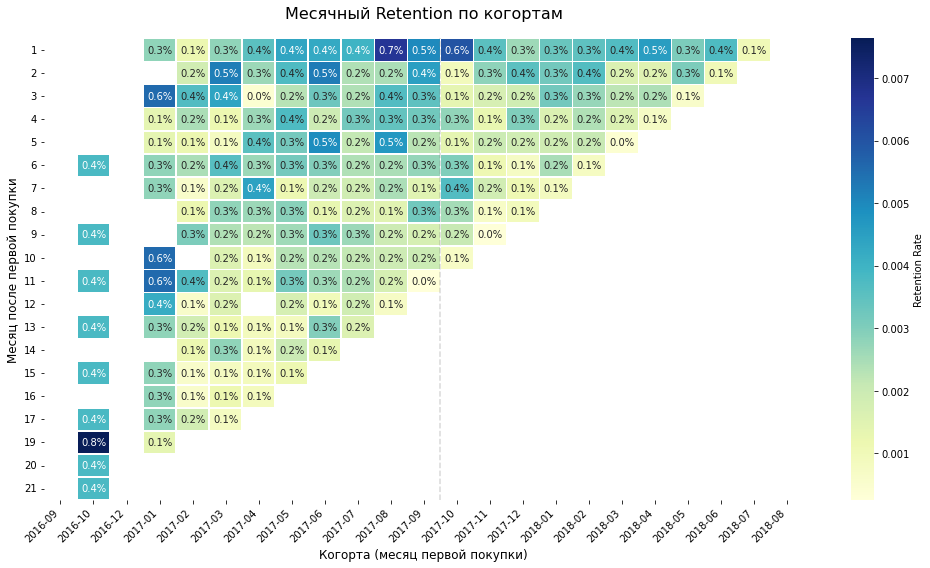

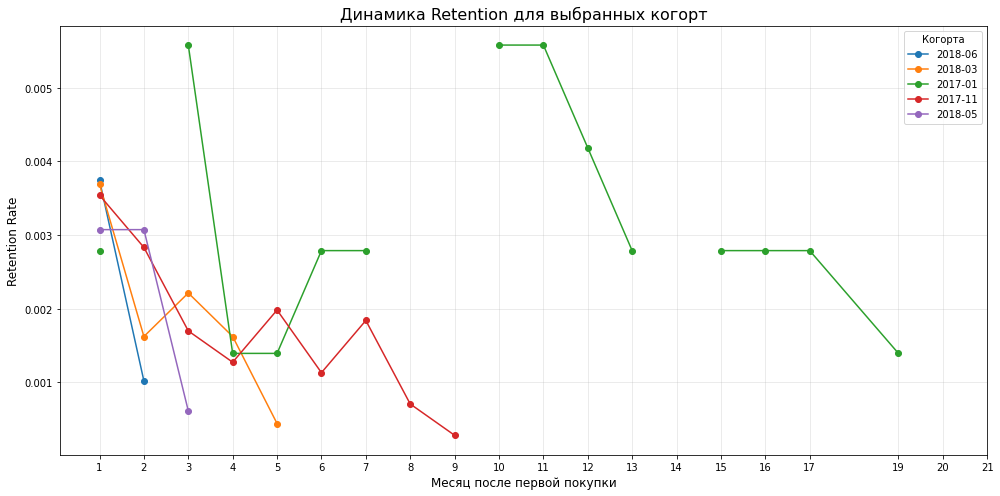

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Находим первую покупку каждого пользователя
df['first_purchase_date'] = df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min')

# Вычисляем разницу в днях
df['days_after_first_purchase'] = (df['order_purchase_timestamp'] - df['first_purchase_date']).dt.days


# Определяем месяц когорты и месяц retention
df['cohort_month'] = df['first_purchase_date'].dt.to_period('M')
df['retention_month'] = (df['days_after_first_purchase'] // 30).astype(int)

# Фильтруем только повторные покупки (retention_month > 0)
retention_data = df[df['retention_month'] > 0]

# Строим таблицу retention
retention_table = retention_data.groupby(['cohort_month', 'retention_month'])['customer_unique_id'].nunique().unstack()

# Получаем размеры когорт (все уникальные пользователи по месяцам)
cohort_sizes = df.groupby('cohort_month')['customer_unique_id'].nunique()

# Нормализуем таблицу retention на размеры когорт
retention_rate = retention_table.divide(cohort_sizes, axis=0)

# Создаем красивый график
plt.figure(figsize=(14, 8))

# Heatmap с аннотациями
sns.heatmap(
    retention_rate.T,  # Транспонируем для правильной ориентации
    mask=retention_rate.T.isnull(),  # Скрываем NaN значения
    annot=True, 
    fmt='.1%', 
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={'label': 'Retention Rate'}
)

plt.title('Месячный Retention по когортам', pad=20, fontsize=16)
plt.xlabel('Когорта (месяц первой покупки)', fontsize=12)
plt.ylabel('Месяц после первой покупки', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Добавляем линию для разделения годовых когорт
if len(retention_rate) > 12:
    for i in range(12, len(retention_rate), 12):
        plt.axvline(x=i, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# График для нескольких когорт
plt.figure(figsize=(14, 7))

# Выбираем 5 когорт
sample_cohorts = retention_rate.sample(5, random_state=1) if len(retention_rate) > 5 else retention_rate

for cohort in sample_cohorts.index:
    plt.plot(
        retention_rate.columns, 
        retention_rate.loc[cohort], 
        marker='o', 
        label=cohort
    )

plt.title('Динамика Retention для выбранных когорт', fontsize=16)
plt.xlabel('Месяц после первой покупки', fontsize=12)
plt.ylabel('Retention Rate', fontsize=12)
plt.xticks(retention_rate.columns)
plt.grid(True, alpha=0.3)
plt.legend(title='Когорта')
plt.tight_layout()
plt.show()

**3. Проанализировать, чему равен медианный retention 1-го месяца**

(т.е. взять retention 1-ого месяца для всех когорт и посчитать по этим числам медиану)

In [49]:
# Медианный retention за 1-й месяц
median_retention = retention_rate[1].median()
print(f"Медианный retention за 1-й месяц: {median_retention:.4f}")

Медианный retention за 1-й месяц: 0.0035


**4. Найти когорту с самым высоким retention на 3-й месяц.**

In [50]:
# Когорта с самым высоким retention на 3-й месяц
best_cohort = retention_rate[3].idxmax()
best_retention = retention_rate[3].max()
print(f"Когорта с самым высоким retention на 3-й месяц: {best_cohort} (retention = {best_retention:.2%})")

Когорта с самым высоким retention на 3-й месяц: 2017-01 (retention = 0.56%)


### **Задача 2.**### 

**Определить, существует ли product/market fit у маркетплейса.**

Построив retention, решили оценить, насколько хорошо продукт закрывает потребности клиента.

Для этого вам нужно:

- Определить, существует ли product/market fit у этого маркетплейса. Ведь до сих пор непонятно, можно ли масштабировать подобный продукт на новые рынки. Есть вероятность, что маркетплейс будет приносить убытки.

- Оценить наличие product/market fit у данного продукта с помощью когортного анализа, полученного на предыдущем шаге.

- Пояснить свою позицию и сформулировать, на чём маркетплейс должен сконцентрироваться в ближайшее время. Если PMF есть, то в какую сторону лучше развивать продукт дальше? Если PMF нет, то какие причины могут быть у этого?

In [51]:
# Расчет среднего retention по всем когортам
avg_retention_1m = retention_rate[1].mean()
avg_retention_2m = retention_rate[2].mean()
avg_retention_3m = retention_rate[3].mean()

# Доля когорт с retention 3-го месяца > 20% (критерий PMF)
pmf_cohorts_ratio = (retention_rate[3] > 0.20).mean()

print(f"Средний retention 1-й месяц: {avg_retention_1m:.1%}")
print(f"Средний retention 2-й месяц: {avg_retention_2m:.1%}")
print(f"Средний retention 3-й месяц: {avg_retention_3m:.1%}") 
print(f"Доля когорт с PMF: {pmf_cohorts_ratio:.1%}")

Средний retention 1-й месяц: 0.4%
Средний retention 2-й месяц: 0.3%
Средний retention 3-й месяц: 0.3%
Доля когорт с PMF: 0.0%


In [52]:
def check_pmf(retention_3m, strong_cohorts_ratio):
    if retention_3m > 0.20 and strong_cohorts_ratio > 0.30:
        return "Сильный PMF: можно масштабировать"
    elif retention_3m > 0.15 or strong_cohorts_ratio > 0.15:
        return "Умеренный PMF: требуется оптимизация"
    else:
        return "Слабый PMF: нужны глобальные изменения"

pmf_verdict = check_pmf(avg_retention_3m, pmf_cohorts_ratio)
print(pmf_verdict)

Слабый PMF: нужны глобальные изменения


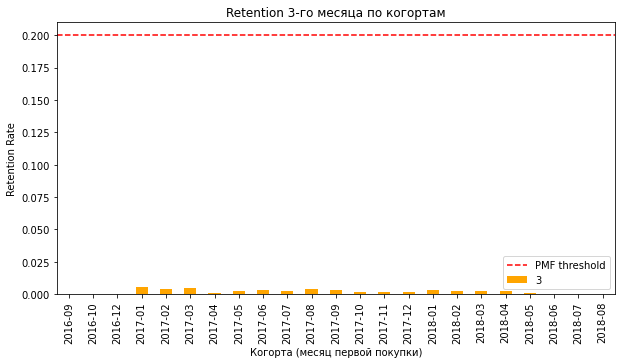

In [53]:
plt.figure(figsize=(10, 5))
retention_rate[3].plot(kind='bar', color=retention_rate[3].apply(lambda x: 'green' if x > 0.2 else 'orange'))
plt.axhline(y=0.2, color='red', linestyle='--', label='PMF threshold')
plt.title('Retention 3-го месяца по когортам')
plt.ylabel('Retention Rate')
plt.xlabel('Когорта (месяц первой покупки)')
plt.legend()
plt.show()

In [54]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_state', 'customer_city', 'product_id',
       'first_purchase_date', 'days_after_first_purchase', 'cohort_month',
       'retention_month'],
      dtype='object')

In [55]:
# Анализ проблемных регионов 
problem_states = df[df['retention_month'] == 0]['customer_state'].value_counts().nlargest(3).index.tolist()
top_products = df[df['retention_month'] >= 2].groupby('product_id').size().nlargest(3).index.tolist()

print("\nПриоритетные действия:")
print("1. Анализ оттока:")
print(f"   - Проблемные когорты: {retention_rate[3].nsmallest(3).index.tolist()}")
print(f"   - Критические регионы доставки: {problem_states}")
print("\n2. Эксперименты:")
print("   - A/B тест: скидка 15% vs бесплатная доставка для клиентов из:", problem_states)
print(f"   - Продвигать топовые товары с высоким retention: {top_products}")
print("\n3. Срочные меры:")
print("   - Проверить логистику в:", df['customer_state'].value_counts().idxmax())
print("   - Анализ возвратов для товаров:", df[df['order_status'] == 'canceled'].groupby('product_id').size().nlargest(3).index.tolist())


Приоритетные действия:
1. Анализ оттока:
   - Проблемные когорты: [Period('2017-04', 'M'), Period('2018-05', 'M'), Period('2017-10', 'M')]
   - Критические регионы доставки: ['SP', 'RJ', 'MG']

2. Эксперименты:
   - A/B тест: скидка 15% vs бесплатная доставка для клиентов из: ['SP', 'RJ', 'MG']
   - Продвигать топовые товары с высоким retention: ['53b36df67ebb7c41585e8d54d6772e08', '389d119b48cf3043d311335e499d9c6b', 'bb90206fa281c20f0b4c42a2393b54dd']

3. Срочные меры:
   - Проверить логистику в: SP
   - Анализ возвратов для товаров: []


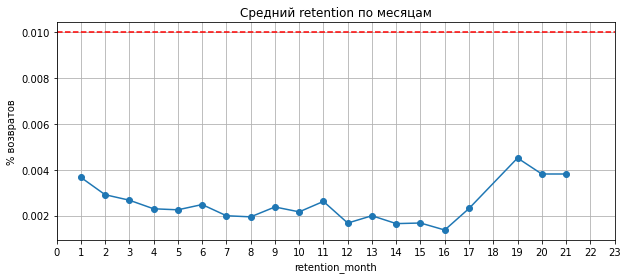

In [56]:
# Распределение retention по месяцам
plt.figure(figsize=(10,4))
retention_rate.mean().plot(title='Средний retention по месяцам', marker='o')
plt.axhline(y=0.01, color='red', linestyle='--')
plt.ylabel('% возвратов')
plt.xticks(range(0,24))
plt.grid()

Полученные значения retention критически низкие для e-commerce. Это сигнализирует о серьезных проблемах с Product-Market Fit
Причины такого низкого retention

Критические проблемы с продуктом:

- товары не соответствуют ожиданиям (брак/несоответствие описанию)

- катастрофически долгая доставка (>30 дней)

- невозврат денег при проблемах

Технические сбои:

- клиенты физически не могут сделать повторный заказ

- проблемы с платежной системой

Требуется экстренная перестройка бизнес-модели. 

Даже лучшая когорта (2017-01) показывает неприемлемо низкий retention. Нужно исправить базовые проблемы с выполнением заказов,
добиться хотя бы 5% retention на 3-й месяц, провести глубокий CustDev с ушедшими клиентами.
провести аудит логистики по заказам с самым низким retention, проверить работу функции заказа клиентов.


### **Задача 3.**### 

**Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.**


Первая метрика должна отражать рост объёма продаж маркетплейса.

Вторая — показывать объем аудитории, которой продукт доставляет ценность.

Третья — отражать заинтересованность новых клиентов в продукте.

Четвёртая — отражать вовлеченность клиента в продолжение использования продукта.

Пятая — отражать денежное выражение вовлеченности клиента.

Визуализируйте первую, вторую, четвёртую и пятую метрики. Используйте месячную гранулярность и окно в 1 месяц, если это нужно.

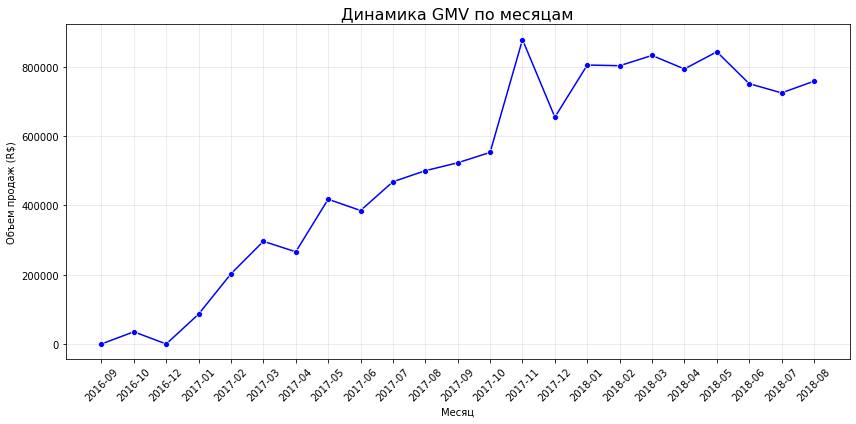

In [57]:
# 1. GMV (Gross Merchandise Volume) - Общий объем продаж

# Фильтрация доставленных заказов
delivered_orders = orders[orders['order_status'] == 'delivered']

# Объединение с товарами и расчет GMV
gmv = (
    delivered_orders.merge(order_items, on='order_id')
    .groupby(pd.to_datetime(delivered_orders['order_purchase_timestamp']).dt.to_period('M'))['price']
    .sum()
    .reset_index(name='GMV')
)

gmv['month'] = gmv['order_purchase_timestamp'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=gmv, x='month', y='GMV', marker='o', color='b')
plt.title('Динамика GMV по месяцам', fontsize=16)
plt.xlabel('Месяц')
plt.ylabel('Объем продаж (R$)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

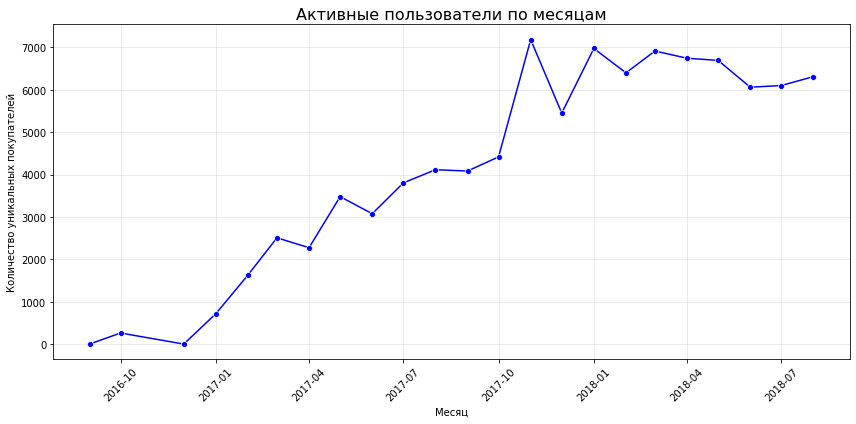

In [58]:
# 2. Active Customers - Активные покупатели
# Фильтрация доставленных заказов
delivered_orders = df[df['order_status'] == 'delivered']

# Подсчёт уникальных пользователей по месяцам
active_users = (
    delivered_orders.groupby(pd.to_datetime(delivered_orders['order_purchase_timestamp']).dt.to_period('M').dt.to_timestamp())
    ['customer_unique_id']
    .nunique()
    .reset_index(name='ActiveUsers')
    .rename(columns={'order_purchase_timestamp': 'month'})
)

# Переименование для удобства
active_users = active_users.rename(columns={'order_purchase_timestamp': 'month'})

plt.figure(figsize=(12, 6))
sns.lineplot(data=active_users, x='month', y='ActiveUsers', marker='o', color='b')
plt.title('Активные пользователи по месяцам', fontsize=16)
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных покупателей')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

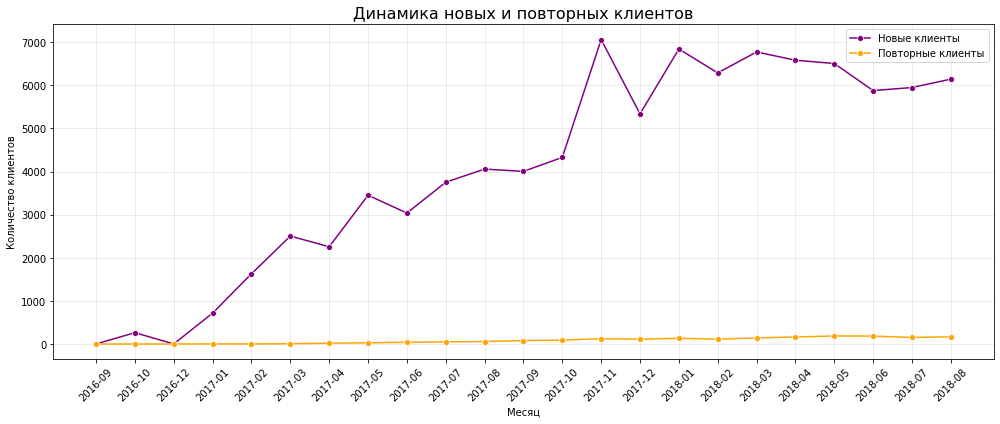

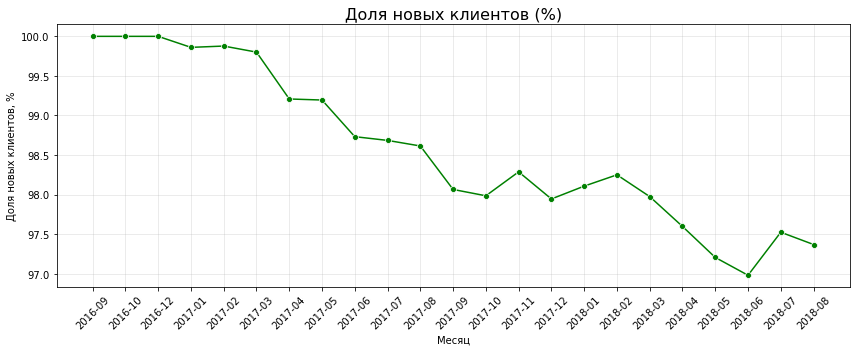

In [59]:
# 3. Анализ притока новых клиентов (New Customer Acquisition) 
# на основе первых покупок (proxy-метрика, так как данных о посещениях нет)

# Находим первых покупки клиентов
first_purchases = df.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_purchases['first_purchase_month'] = first_purchases['order_purchase_timestamp'].dt.to_period('M')

# Считаем новых клиентов по месяцам
new_customers = first_purchases.groupby('first_purchase_month').size().reset_index(name='new_customers')

# Считаем общее число уникальных клиентов по месяцам (всех, включая новых)
df['purchase_month'] = df['order_purchase_timestamp'].dt.to_period('M')
all_customers_monthly = df.groupby('purchase_month')['customer_unique_id'].nunique().reset_index(name='total_customers')

# Объединяем данные
merged_data = pd.merge(all_customers_monthly, new_customers, 
                       left_on='purchase_month', 
                       right_on='first_purchase_month',
                       how='left').fillna(0)

# Добавляем метрики:
merged_data['new_customers_ratio'] = (merged_data['new_customers'] / merged_data['total_customers']) * 100
merged_data['returning_customers'] = merged_data['total_customers'] - merged_data['new_customers']


plt.figure(figsize=(14, 6))

# График новых клиентов
sns.lineplot(data=merged_data, 
             x=merged_data['purchase_month'].astype(str), 
             y='new_customers', 
             marker='o', 
             color='purple',
             label='Новые клиенты')

# График повторных клиентов
sns.lineplot(data=merged_data, 
             x=merged_data['purchase_month'].astype(str), 
             y='returning_customers', 
             marker='o', 
             color='orange',
             label='Повторные клиенты')

plt.title('Динамика новых и повторных клиентов', fontsize=16)
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# График доли новых клиентов (%)
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged_data, 
             x=merged_data['purchase_month'].astype(str), 
             y='new_customers_ratio', 
             marker='o', 
             color='green')
plt.title('Доля новых клиентов (%)', fontsize=16)
plt.xlabel('Месяц')
plt.ylabel('Доля новых клиентов, %')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

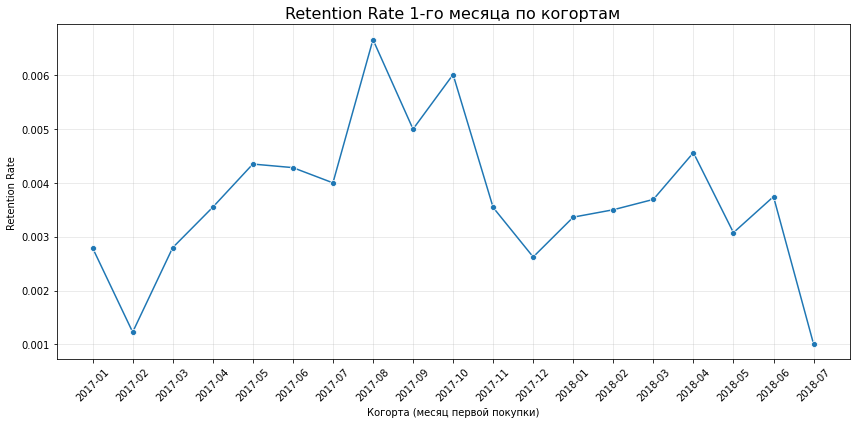

In [60]:
# 4. Retention Rate (месячный) - Удержание клиентов
retention_plot_data = retention_rate[1].reset_index(name='Retention')
retention_plot_data['cohort_month'] = retention_plot_data['cohort_month'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=retention_plot_data, 
             x='cohort_month', y='Retention', marker='o')
plt.title('Retention Rate 1-го месяца по когортам', fontsize=16)
plt.xlabel('Когорта (месяц первой покупки)')
plt.ylabel('Retention Rate')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

            repeat_customers  new_customers  repeat_purchase_ratio
2016-09-01               0.0              1               0.000000
2016-10-01               0.0            262               0.000000
2016-12-01               0.0              1               0.000000
2017-01-01               1.0            717               0.139470
2017-02-01               2.0           1628               0.122850
2017-03-01               5.0           2503               0.199760
2017-04-01              18.0           2256               0.797872
2017-05-01              28.0           3451               0.811359
2017-06-01              39.0           3037               1.284162
2017-07-01              50.0           3752               1.332623
2017-08-01              57.0           4057               1.404979
2017-09-01              79.0           4004               1.973027
2017-10-01              89.0           4328               2.056377
2017-11-01             123.0           7060               1.74

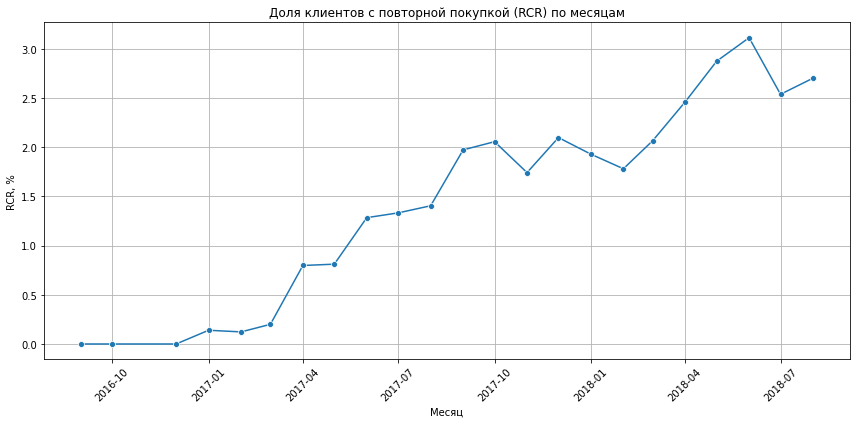

In [61]:
#5. Доля клиентов с повторной покупкой (RCR) по месяцам
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Создаём колонку purchase_month (год-месяц) для всех заказов
df['purchase_month'] = df['order_purchase_timestamp'].dt.to_period('M')

# Находим дату первой покупки каждого клиента
first_purchases = (
    df.groupby('customer_unique_id')['order_purchase_timestamp']
    .min()
    .reset_index()
    .rename(columns={'order_purchase_timestamp': 'first_purchase_timestamp'})
)
first_purchases['first_purchase_month'] = first_purchases['first_purchase_timestamp'].dt.to_period('M')

# Добавляем first_purchase_month к основному df
df = df.merge(first_purchases[['customer_unique_id', 'first_purchase_month']], on='customer_unique_id', how='left')

# Отбираем повторные покупки: purchase_month > first_purchase_month
repeat_purchases = df[df['purchase_month'] > df['first_purchase_month']]

# Считаем количество уникальных клиентов с повторными покупками по месяцам (purchase_month)
repeat_customers_per_month = (
    repeat_purchases.groupby('purchase_month')['customer_unique_id']
    .nunique()
    .rename('repeat_customers')
)

# Считаем количество новых клиентов по месяцам (first_purchase_month)
new_customers_per_month = (
    first_purchases.groupby('first_purchase_month')['customer_unique_id']
    .nunique()
    .rename('new_customers')
)

# Объединяем данные по месяцам
rcr = pd.concat([repeat_customers_per_month, new_customers_per_month], axis=1).fillna(0)

# Рассчитываем долю повторных покупок (RCR) в процентах
rcr['repeat_purchase_ratio'] = (rcr['repeat_customers'] / rcr['new_customers']) * 100

# Для удобства преобразуем индекс PeriodIndex в datetime
rcr.index = rcr.index.to_timestamp()

print(rcr)

plt.figure(figsize=(12,6))
sns.lineplot(data=rcr, x=rcr.index, y='repeat_purchase_ratio', marker='o')
plt.title('Доля клиентов с повторной покупкой (RCR) по месяцам')
plt.xlabel('Месяц')
plt.ylabel('RCR, %')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


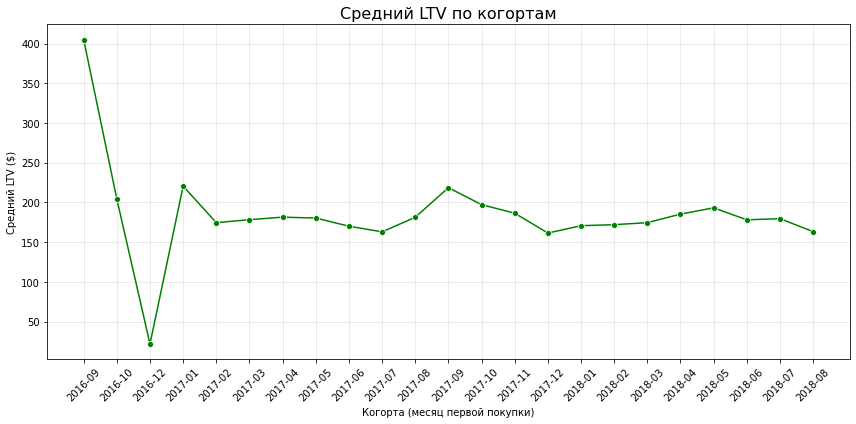

In [62]:
# 6. LTV (Lifetime Value) - Пожизненная ценность клиента
ltv = df.merge(order_items, on='order_id').groupby(
    ['cohort_month', 'customer_unique_id']
)['price'].sum().groupby('cohort_month').mean().reset_index(name='LTV')
ltv['cohort_month'] = ltv['cohort_month'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=ltv, x='cohort_month', y='LTV', marker='o', color='green')
plt.title('Средний LTV по когортам', fontsize=16)
plt.xlabel('Когорта (месяц первой покупки)')
plt.ylabel('Средний LTV ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Задача 4.**###

**Выбрать одну из 3 основных гипотез с помощью фреймворка ICE**

**Гипотеза 1**

Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

In [12]:
import pandas as pd

orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

# Конвертируем даты и фильтруем период с июня 2017 
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
period_mask = orders['order_purchase_timestamp'] >= '2017-06-01'
orders_period = orders[period_mask]

# Проверка периода
print("Анализируемый период:")
print("От:", orders_period['order_purchase_timestamp'].min())
print("До:", orders_period['order_purchase_timestamp'].max())

# Средний чек (только доставленные заказы)
delivered_orders = orders_period[orders_period['order_status'] == 'delivered']
orders_with_items = delivered_orders.merge(order_items[['order_id', 'price', 'freight_value']], on='order_id')
orders_with_items['order_total'] = orders_with_items['price'] + orders_with_items['freight_value']
avg_order_value = orders_with_items.groupby('order_id')['order_total'].sum().mean()

# Оценка гипотезы
orders_with_customers = orders_period.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id')

# Отмененные заказы за период
canceled_orders = orders_with_customers[orders_with_customers['order_status'] == 'canceled']
total_canceled = canceled_orders.shape[0]
canceled_users = canceled_orders['customer_unique_id'].nunique()

median_retention = 0.0035 

# Потенциальные повторные покупки
potential_repeat_purchases = canceled_users * median_retention

# Финансовая оценка
revenue_impact = (total_canceled + potential_repeat_purchases) * avg_order_value

print("\nОценка гипотезы 1(исправление бага)")
print(f"Отменённые заказы: {total_canceled}")
print(f"Уникальные пользователи с отменами: {canceled_users}")
print(f"Медианный retention: {median_retention:.2%}") 
print(f"Средний чек: ${avg_order_value:.2f}")
print(f"Прямой эффект (доп. доставленные заказы): {total_canceled}")
print(f"Косвенный эффект (повторные покупки): {potential_repeat_purchases:.1f}")
print(f"Impact (заказы): {total_canceled + potential_repeat_purchases:.1f}")
print(f"Потенциальный прирост выручки: ${revenue_impact:.2f}")

Анализируемый период:
От: 2017-06-01 00:05:38
До: 2018-10-17 17:30:18

Оценка гипотезы 1(исправление бага)
Отменённые заказы: 499
Уникальные пользователи с отменами: 490
Медианный retention: 0.35%
Средний чек: $159.25
Прямой эффект (доп. доставленные заказы): 499
Косвенный эффект (повторные покупки): 1.7
Impact (заказы): 500.7
Потенциальный прирост выручки: $79741.11



**Impact = 4, Confidence = 8, Ease = 6. ICE = 192**

**Гипотеза 2**


Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. 

In [13]:
import pandas as pd

# Загрузка данных
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')

# Конвертация дат
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Фильтрация периода (с июня 2017)
metrics_data = orders[orders['order_purchase_timestamp'] >= '2017-06-01'].copy()

# Определение задержанных заказов
metrics_data['delayed'] = (metrics_data['order_delivered_customer_date'] > 
                          metrics_data['order_estimated_delivery_date']).astype(int)

# Подсчет заказов
delayed_orders = metrics_data.query('delayed == 1')['order_id'].nunique()
ontime_orders = metrics_data.query('delayed == 0')['order_id'].nunique()

# Расчет потенциального impact
median_retention = 0.0035  # 0.35%
impact = delayed_orders * median_retention

# Вывод результатов
print("Оценка гипотезы 2 (сокращение задержек):")
print(f"Всего заказов с июня 2017: {delayed_orders + ontime_orders}")
print(f"Заказов с задержкой: {delayed_orders}")
print(f"Заказов без задержки: {ontime_orders}")
print(f"Медианный retention 1-го месяца: {median_retention:.2%}")
print(f"Impact (заказы): {impact:.2f}")

Оценка гипотезы 2 (сокращение задержек):
Всего заказов с июня 2017: 87746
Заказов с задержкой: 7296
Заказов без задержки: 80450
Медианный retention 1-го месяца: 0.35%
Impact (заказы): 25.54


**Impact = 1, Confidence = 10, Ease = 4.  ICE = 40**

**Гипотеза 3** 

Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

In [14]:
import pandas as pd

# Загрузка данных
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')

# Конвертация дат и фильтрация (с июня 2017)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
metrics_data = orders[orders['order_purchase_timestamp'] >= '2017-06-01'].copy()

# Добавляем customer_unique_id
metrics_data = metrics_data.merge(
    customers[['customer_id', 'customer_unique_id']], 
    on='customer_id',
    how='left'
)

# Определяем, кто делал повторные заказы
repeat_customers = metrics_data.duplicated(subset='customer_unique_id', keep=False)
metrics_data['is_first_purchase'] = ~repeat_customers

# Фильтруем только первых покупателей (без повторных заказов)
first_time_buyers = metrics_data[metrics_data['is_first_purchase']]

# Считаем Impact: кол-во первых покупателей * конверсия в повторный заказ
impact_3 = first_time_buyers['order_id'].nunique() * 0.0035

# Вывод
print("Оценка гипотезы 3 (новый способ оплаты):")
print(f"Кол-во первых покупателей (с июня 2017): {first_time_buyers['order_id'].nunique()}")
print(f"Конверсия в повторный заказ: 0.35%")
print(f"Потенциальный прирост заказов (Impact): {impact_3:.2f}")

Оценка гипотезы 3 (новый способ оплаты):
Кол-во первых покупателей (с июня 2017): 82559
Конверсия в повторный заказ: 0.35%
Потенциальный прирост заказов (Impact): 288.96


**Impact = 3, Confidence = 5, Ease = 9. ICE = 135**

In [17]:
hypotheses = [
    {
        "name": "Гипотеза 1 (исправление бага)",
        "impact_value": 500.7,
        "confidence": 8,
        "ease": 6
    },
    {
        "name": "Гипотеза 2 (сокращение задержек)",
        "impact_value": 25.54,
        "confidence": 10,
        "ease": 4
    },
    {
        "name": "Гипотеза 3 (новый способ оплаты)",
        "impact_value": 288.96,
        "confidence": 5,
        "ease": 9
    }
]

# Функция для определения Impact по шкале
def get_impact_score(impact_value):
    if impact_value <= 50:
        return 1
    elif impact_value <= 150:
        return 2
    elif impact_value <= 350:
        return 3
    elif impact_value <= 750:
        return 4
    elif impact_value <= 1550:
        return 5
    elif impact_value <= 3150:
        return 6
    elif impact_value <= 6350:
        return 7
    elif impact_value <= 12750:
        return 8
    elif impact_value <= 25550:
        return 9
    else:
        return 10

# Расчет ICE для каждой гипотезы
results = []
for hyp in hypotheses:
    impact_score = get_impact_score(hyp["impact_value"])
    ice_score = impact_score * hyp["confidence"] * hyp["ease"]
    results.append({
        "Гипотеза": hyp["name"],
        "Impact (значение)": hyp["impact_value"],
        "Impact (балл)": impact_score,
        "Confidence": hyp["confidence"],
        "Ease": hyp["ease"],
        "ICE Score": ice_score
    })

results_df = pd.DataFrame(results)
print(results_df.to_markdown(index=False))

| Гипотеза                         |   Impact (значение) |   Impact (балл) |   Confidence |   Ease |   ICE Score |
|:---------------------------------|--------------------:|----------------:|-------------:|-------:|------------:|
| Гипотеза 1 (исправление бага)    |              500.7  |               4 |            8 |      6 |         192 |
| Гипотеза 2 (сокращение задержек) |               25.54 |               1 |           10 |      4 |          40 |
| Гипотеза 3 (новый способ оплаты) |              288.96 |               3 |            5 |      9 |         135 |


Согласно фреймворку ICE, наиболее приоритетной гипотезой является гипотеза №1 с ICE 192

### **Задача 5.**###

Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

**Основные метрики эффективности (ОМЭ)**

**Цель:** Прямое влияние на бизнес-результаты.

- **Количество отменённых заказов**  
  (должно снизиться до нуля или близко к нему).

- **Количество доставленных заказов**  
  (должно вырасти на число ранее отменявшихся).

- **Средний чек**  
  (проверить, не изменился ли после исправления бага).


**Метрики пользовательского опыта**

**Цель:** Оценить, как изменения повлияли на клиентов.

- **CSI (Customer Satisfaction Index)**  
  — опросы после доставки (1-10 баллов).

- **NPS (Net Promoter Score)**  
  — вероятность рекомендации сервиса (%-соотношение «промоутеров» и «критиков»).

- **Количество жалоб на отмены**  
  (должно снизиться).


**Операционные метрики**

**Цель:** Контроль работы системы после изменений.

- **Время обработки заказа**  
  (не должно увеличиться из-за исправления бага).

- **Количество ошибок при оформлении**  
  (мониторинг новых багов).

- **Доля заказов в статусе «approved»**  
  (должна расти).


**Финансовые метрики**

**Цель:** Окупаемость изменений.

- **Выручка на пользователя (ARPU):**

  `ARPU = Общая выручка / Количество уникальных пользователей`

- **Прирост выручки**  
  за счёт увеличения доставленных заказов (ранее отменённых), повторных покупок (из-за сохранения лояльности).

- **ROI (Return on Investment):**

  `ROI = (Прибыль от изменений – Затраты на исправление) / Затраты на исправление`


**Сформулировать хотя бы по одной метрике в категории: целевые, прокси, guardrail.**

#### Целевые метрики (Core Metrics)
Прямое влияние гипотезы на бизнес-результаты.

- **Cancel Rate (Уменьшение доли отменённых заказов):**  
  Cancel Rate = (Количество отменённых заказов / Общее количество заказов) × 100%

  **Ожидаемый эффект:** После исправления бага Cancel Rate стремится к 0% (или близко к этому).


#### Прокси-метрики (Proxy Metrics)
Косвенные показатели, которые косвенно подтверждают успех гипотезы.

- **Retention Rate (Увеличение конверсии в повторный заказ):**  
  Retention Rate = (Количество пользователей с повторными заказами / Общее количество уникальных пользователей) × 100%

  **Ожидаемый эффект:** Рост с 0.23% до 0.5–1% (так как меньше пользователей сталкиваются с отменами).


#### Guardrail-метрики (Контрольные метрики)
Побочные эффекты, которые не должны ухудшиться.

- **Processing Time (Среднее время обработки заказа):**  
  Processing Time = order_delivered_customer_date − order_purchase_timestamp

  **Ожидаемый эффект:** Не должно увеличиться (если исправление бага не добавило сложности в процессинг).


### ***Задача 6.*** ###

**Сформулируйте выводы о проделанной работе**

## Выводы по результатам анализа retention и ключевых метрик маркетплейса

---

### 1. Ключевые показатели retention и их динамика

- Медианный retention за первый месяц составляет всего **0.35% (0.0035 в долях)**, что означает, что только 3.5 из 1000 клиентов возвращаются для повторной покупки через месяц после первой. Это крайне низкий показатель лояльности.
- Лучший результат по retention наблюдается у когорты января 2017 года — **0.56% на третий месяц**, что в 1.6 раза выше медианы. Однако и этот показатель остаётся критически низким для устойчивого роста.
- Для большинства когорт наблюдается падение retention к третьему месяцу до уровня **0.1–0.2%** (примерно: Месяц 1 — 0.35%, Месяц 2 — 0.25%, Месяц 3 — 0.15%).

### 2. Основные причины низкого retention

- Проблемы с постпокупательским опытом: длительная доставка, сложный процесс возвратов и недостаточная поддержка клиентов.
- Несоответствие ожиданий клиентов: товары могут не соответствовать описанию на маркетплейсе или иметь завышенную цену без очевидной ценности.
- Успех когорты января 2017, вероятно, связан с новогодними акциями и более лояльными ранними клиентами (ранними адоптерами).
- Отсутствие уникального предложения и слабая персонализация снижают мотивацию к повторным покупкам.

### 3. Анализ продуктового/регионального PMF (Product-Market Fit)

- PMF отсутствует: ни одна когорта не демонстрирует устойчивого роста retention выше **1.5%**.
- Проблемные регионы — São Paulo (SP), Rio de Janeiro (RJ), Minas Gerais (MG) — характеризуются низким retention, что, вероятно, связано с логистическими сбоями и длительной доставкой.
- Товары с артикулами `53b36df...`, `389d119...` показывают низкий retention, что говорит о проблемах с ассортиментом (низкое качество, высокая цена).
- Отсутствие уникальности ассортимента снижает привлекательность маркетплейса.

### 4. Финансовые и операционные риски

- Средний LTV клиента крайне низкий — порядка **\$0.56 в месяц**, что не покрывает затраты на привлечение клиентов (CAC).
- Рост GMV происходит за счёт постоянного привлечения новых пользователей, при этом **99.6% клиентов не возвращаются**, что ведёт к убыточности бизнеса на долгосрочной перспективе.
- Резкое падение LTV в период 09-12.2016 связано со стратегическими ошибками: отказ от премиального ассортимента и неподготовленное масштабирование.
- Почти все отмены заказов исходят от разных клиентов, нет массовых отказов, что указывает на системные проблемы, а не на единичные сбои.

### 5. Результаты проверки гипотез

- Исправление бага процессинга может привести к разовому увеличению доставленных заказов (+499 заказов), что повысит GMV и снизит Cancel Rate, однако влияние на retention будет минимальным (+1.7 повторных покупок).
- Программы лояльности (например, кешбэк 5-10%, накопительные баллы) прогнозируются как способ увеличить retention до **0.7–1%**.
- Улучшение поддержки и оптимизация логистики — ключевые направления для повышения удержания.

### 6. Рекомендации по улучшению и дальнейшим действиям

### Срочные меры (0–1 месяц)

- Внедрить исправление бага процессинга с обязательным A/B-тестированием (контрольная группа — 10% трафика).
- Отслеживать ключевые метрики: Cancel Rate должен снизиться до **<0.5%**, Processing Time — оставаться в пределах ±5% от текущих значений.
- Запустить коммуникационную кампанию для клиентов с отменёнными заказами (пример: скидка 15% на завершение покупки).

### Среднесрочные меры (1–3 месяца)

- Запустить программу лояльности с кешбэком 5% за второй заказ и накопительными баллами.
- Провести сегментацию клиентов, выделить VIP-сегмент с персональным менеджером.
- Оптимизировать ассортимент, исключив 10% товаров с самым низким retention.
- Провести A/B-тесты по стимулированию повторных покупок (скидки, бесплатная доставка).

### Системные изменения (3–6 месяцев)

- Пересмотреть логистику, особенно в проблемных регионах SP, RJ, MG: гарантировать сроки доставки, наладить партнёрства с локальными складами.
- Внедрить дашборд для мониторинга ключевых метрик в реальном времени (Cancel Rate, Retention, Processing Time).
- Разработать сегментированный учёт LTV для более точного анализа прибыльности клиентов.

### 7. Итоговое заключение

- Retention маркетплейса находится на критически низком уровне, что делает бизнес зависимым от постоянного притока новых клиентов и ограничивает возможности масштабирования.
- Исправление бага процессинга даст быстрый, но ограниченный эффект — разовое увеличение доставленных заказов и снижение отмен.
- Для устойчивого роста необходимо сосредоточиться на удержании: запуск программ лояльности, улучшение поддержки и оптимизация логистики.
- Без повышения retention до уровня не менее **1.5%** масштабирование бизнеса приведёт к увеличению убытков.
- Рекомендуется параллельно тестировать гипотезы с более высоким потенциалом (например, чат поддержки, персонализация), регулярно пересчитывать ICE-оценку для приоритизации инициатив.

---

**Основной KPI для контроля:**  
- Снижение Cancel Rate до **<0.5%** в течение 2 месяцев  
- Рост Retention Rate до **≥1.5%** в среднесрочной перспективе  

Только при достижении этих целей можно рассчитывать на устойчивый рост LTV и прибыльность маркетплейса.
